In [1]:
%%capture
%%bash

apt update
# need git and build dependencies https://github.com/pyenv/pyenv/wiki\#suggested-build-environment
DEBIAN_FRONTEND=noninteractive apt install -y python3 python3-distutils python-is-python3 git \
    build-essential libssl-dev zlib1g-dev \
    libbz2-dev libreadline-dev libsqlite3-dev curl \
    libncursesw5-dev xz-utils tk-dev libxml2-dev libxmlsec1-dev libffi-dev liblzma-dev

# install pyenv
curl https://pyenv.run | bash
export PYENV_ROOT="$HOME/.pyenv"
command -v pyenv >/dev/null || export PATH="$PYENV_ROOT/bin:$PATH"
eval "$(pyenv init -)"

# compile python 3.8
pyenv install 3.8

# prepare venv
pyenv global 3.8
pip3 install virtualenv
mkdir -p ~/.cache/pytriton/
python -mvenv ~/.cache/pytriton/python_backend_interpreter --copies --clear
source ~/.cache/pytriton/python_backend_interpreter/bin/activate
pip3 install numpy~=1.21 pyzmq~=23.0

# recover system python
deactivate
pyenv global system

In [2]:
# Install pytriton in a way that you can use it with GPU on Colab or any other 
# option that uses it
!pip install -q nvidia-pytriton awscli

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.4/37.4 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.9/62.9 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 9.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 82.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [3]:
%%bash
# mkdir model-repository
# aws  --no-sign-request  https://uk1s3.embassy.ebi.ac.uk s3 cp  --endpoint-url s3://model-repository/cellpose-train model-repository
aws s3 sync --no-sign-request --endpoint-url https://uk1s3.embassy.ebi.ac.uk s3://model-repository/cellpose-train model-repository/cellpose-train
aws s3 sync --no-sign-request --endpoint-url https://uk1s3.embassy.ebi.ac.uk s3://model-repository/cellpose-predict model-repository/cellpose-predict
aws s3 cp --no-sign-request --endpoint-url  https://s3.imjoy.io s3://public-datasets/cellpose-triton-gpu.tar.gz model-repository

ls 

# wget http://s3.imjoy.io/public-datasets/cellpose-triton-gpu.tar.gz
rm -R model-repository/*/.ipynb_checkpoints 
# rm 
ls -al model-repository/cellpose-predict/

download: s3://model-repository/cellpose-train/1/__pycache__/interactive_cellpose.cpython-38.pyc to model-repository/cellpose-train/1/__pycache__/interactive_cellpose.cpython-38.pyc
download: s3://model-repository/cellpose-train/1/__pycache__/model.cpython-38.pyc to model-repository/cellpose-train/1/__pycache__/model.cpython-38.pyc
download: s3://model-repository/cellpose-train/1/predict.py to model-repository/cellpose-train/1/predict.py
download: s3://model-repository/cellpose-train/1/test_triton.py to model-repository/cellpose-train/1/test_triton.py
download: s3://model-repository/cellpose-train/1/__pycache__/utils.cpython-38.pyc to model-repository/cellpose-train/1/__pycache__/utils.cpython-38.pyc
download: s3://model-repository/cellpose-train/1/model.py to model-repository/cellpose-train/1/model.py
download: s3://model-repository/cellpose-train/1/interactive_cellpose.py to model-repository/cellpose-train/1/interactive_cellpose.py
download: s3://model-repository/cellpose-train/1/tes

rm: cannot remove 'model-repository/*/.ipynb_checkpoints': No such file or directory


In [4]:
%%writefile server.py
import numpy as np
import torch
from pytriton.decorators import batch
from pytriton.triton import TritonConfig

model = torch.nn.Linear(128, 50).to("cuda").eval()

@batch
def infer_func(**inputs: np.ndarray):
    (input1_batch,) = inputs.values()
    input1_batch_tensor = torch.from_numpy(input1_batch).to("cuda")
    output1_batch_tensor = model(input1_batch_tensor)  # Calling the Python model inference
    output1_batch = output1_batch_tensor.cpu().detach().numpy()
    return [output1_batch]

@batch
def train_func(**inputs: np.ndarray):
    (input1_batch,) = inputs.values()
    input1_batch_tensor = torch.from_numpy(input1_batch).to("cuda")
    output1_batch_tensor = model(input1_batch_tensor)  # Calling the Python model inference
    output1_batch = output1_batch_tensor.cpu().detach().numpy()
    return [output1_batch]

from pytriton.model_config import ModelConfig, Tensor
from pytriton.triton import Triton
from pathlib import Path

triton_config = TritonConfig(
    http_address="0.0.0.0",
    http_port="9930",
    grpc_address="0.0.0.0",
    grpc_port="9920",
    metrics_port="9921",
    model_repository=Path('/content/model-repository'),
)

# Connecting inference callback with Triton Inference Server
with Triton(config=triton_config) as triton:
    '''
    # Load model into Triton Inference Server
    triton.bind(
        model_name="LinearInfer",
        infer_func=infer_func,
        inputs=[
            Tensor(dtype=np.float32, shape=(-1,)),
        ],
        outputs=[
            Tensor(dtype=np.float32, shape=(-1,)),
        ],
        config=ModelConfig(max_batch_size=128)
    )
    triton.bind(
        model_name="LinearTrain",
        infer_func=train_func,
        inputs=[
            Tensor(dtype=np.float32, shape=(-1,)),
        ],
        outputs=[
            Tensor(dtype=np.float32, shape=(-1,)),
        ],
        config=ModelConfig(max_batch_size=128)
    )
    '''
    # Serve model through Triton Inference Server
    triton.serve()

Writing server.py


In [5]:
# Opens a multiplexer terminal on the background, so that you can continue 
# running the notebook but the code on 'server.py' are still running on the 
# background, in this case the server of triton is running on the back
!tmux new-session -d -s my_session_2 "python server.py"

In [8]:
%%bash
# This port has been seen to give errors 
fuser -n tcp 9920
# To check how is the new session of the tmux running, if there is fine or 
tmux capture-pane -p -S - -E - -t my_session_2

 17381I0612 09:49:49.358453 17381 pinned_memory_manager.cc:240] Pinned memory pool is
created at '0x7f4474000000' with size 268435456
I0612 09:49:49.362553 17381 cuda_memory_manager.cc:105] CUDA memory pool is crea
ted on device 0 with size 67108864
I0612 09:49:49.368719 17381 model_lifecycle.cc:459] loading: cellpose-predict:1
I0612 09:49:49.372781 17381 model_lifecycle.cc:459] loading: cellpose-train:1
I0612 09:49:49.380369 17381 python_be.cc:1624] Using Python execution env /conte
nt/model-repository/cellpose-triton-gpu.tar.gz
I0612 09:49:49.387261 17381 python_be.cc:1624] Using Python execution env /conte
nt/model-repository/cellpose-triton-gpu.tar.gz
creating new log file
2023-06-12 09:51:33,837 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2023-06-12 09:51:34,300 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
I0612 09:51:37.177678 17381 python_be.cc:1977] TRITONBACKEND_ModelInstanceInitia
lize: cellpose-predict_0 (GPU device 0)
I0612 09:51:37.204935 17381 python_be.c

9920/tcp:           


In [9]:
import torch
from pytriton.client import ModelClient
import numpy as np

with ModelClient("0.0.0.0:9930", "cellpose-predict") as client:
    result_dict = client.infer_sample(np.zeros([2, 349, 467], dtype='float32'), 
                                      np.array([3]).astype(bytes))

PyTritonClientInferenceServerError: ignored

In [ ]:
%%bash
# To close or kill the session of the server
tmux kill-session -t my_session_2

In [10]:
try:
    # For pyodide in the browser
    import micropip
    await micropip.install(['pyotritonclient', 'kaibu-utils'])
except ImportError:
    # For native python with pip
    import subprocess
    subprocess.call(['pip', 'install', 'pyotritonclient', 'kaibu-utils'])

import io
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pyotritonclient import execute
from kaibu_utils import fetch_image

In [11]:
image = await fetch_image('https://static.imjoy.io/img/img02.png')
image = image.astype('float32')
print("example image downloaded: ", image.shape)

example image downloaded:  (349, 467, 3)


In [12]:
try:
    # JupyterLite/Pyodide
    import pyodide
    import micropip
    await micropip.install('pyotritonclient')
    from imjoy_rpc.utils import open_elfinder
    IS_PYODIDE = True
except ImportError:
    IS_PYODIDE = False
    # For native python with pip
    import subprocess
    subprocess.call(['pip', 'install', 'pyotritonclient', 'imjoy-rpc', 'requests'])

import io
import asyncio
import os
from pyotritonclient import SequenceExcutor, execute
import numpy as np
import pickle
import imageio
import matplotlib.pyplot as plt

%matplotlib inline

def display_image(image, mask):
    # display the output
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.imshow(image)
    ax1.set_title('input image')
    ax2.imshow(mask)
    ax2.set_title('predicted mask')
    plt.show()

async def download_data(url):
    if IS_PYODIDE:
        response = await fetch(url)
        bytes = await response.arrayBuffer()
        bytes = bytes.to_py()
        buffer = io.BytesIO(bytes)
    else:
        import requests
        response = requests.get(url)
        buffer = io.BytesIO(response.content)
    return pickle.load(buffer)

async def train(model_id, samples, epochs=1, model_token = None, resume=True, pretrained_model="cyto", channels=None, diameter=100):
    """
    Train a cellpose model through the BioEngine
    # set pretrained_model to None if you want to train from scratch
    # set model_token to a string if you want to protect the model
    # from overwriting by other users
    """
    seq = SequenceExcutor(
        server_url='http://0.0.0.0:9930',
        model_name="cellpose-train",
        decode_json=True,
        sequence_id=model_id,
    )
    if not channels:
        channels = [1, 2]
    for epoch in range(epochs):
        losses = []
        for (image, labels, info) in samples:
            inputs = [
                image.astype("float32"),
                labels.astype("uint16"),
                {
                    "steps": 16,
                    "pretrained_model": pretrained_model,
                    "resume": resume,
                    "model_token": model_token,
                    "channels": channels,
                    "diam_mean": 30,
                },
            ]
            result = await seq.step(inputs, select_outputs=["info"])
            losses.append(result["info"][0]["loss"])
        avg_loss = np.array(losses).mean()
        print(f"Epoch {epoch}  loss={avg_loss}")
    await seq.end()

async def predict(model_id, samples, channels=None, diameter=100, reload=False):
    """Make predition with the specified cellpose model"""
    # Start the prediction
    seq = SequenceExcutor(
        server_url='http://0.0.0.0:9930',
        model_name="cellpose-predict",
        decode_json=True,
        sequence_id=model_id,
    )
    if not channels:
        channels = [1, 2]
    for i, (image, _, _) in enumerate(samples):
        inputs = [image.astype("float32"), {"channels": channels, "diameter": diameter, "reload": reload}]
        results = await seq.step(inputs, select_outputs=["mask"])
        display_image(image, results['mask'])
    # await seq.end()

async def download_model(model_id, valid_image, valid_labels, model_token = None):
    """
    Download the trained model by its id.
    """
    seq = SequenceExcutor(
        server_url='http://0.0.0.0:9930',
        model_name="cellpose-train",
        decode_json=True,
        sequence_id=model_id,
    )
    print(f"Exporting cellpose model: {model_id}")
    result = await seq.end(
        [
            valid_image.astype("float32"),
            valid_labels.astype("uint16"),
            {
                "resume": True,
                "model_token": model_token,
                "channels": [1, 2],
                "diameter": 100.0,
                "model_format": "bioimageio",
            },
        ],
        decode_json=True,
        select_outputs=["info", "model"],
    )
    # Save the weights
    model_package = result["model"][0]
    filename = result["info"][0]["model_files"][0]
    print(f"Saving model {filename}...")
    if IS_PYODIDE:
        with open_elfinder("/home/"+filename, "wb") as fil:
            fil.write(model_package)
    else:
        with open(os.path.join(os.path.expanduser('~'), filename), "wb") as fil:
            fil.write(model_package)
        
    print(f"Model package saved to {filename}")

Dataset downloaded 4 4
(512, 512, 3) (512, 512, 1)


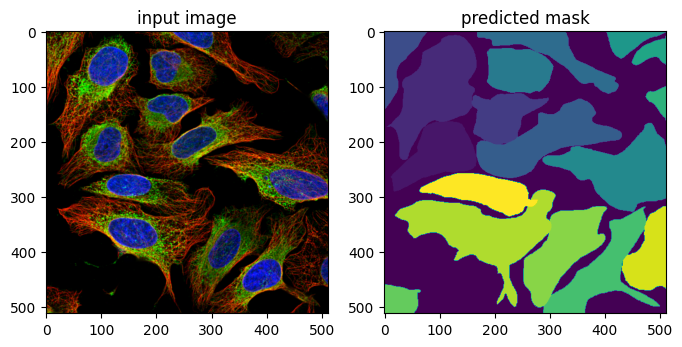

In [13]:
test_samples = await download_data("https://raw.githubusercontent.com/imjoy-team/imjoy-tutorials/master/2-bioengine/test_samples_4.pkl")
train_samples = await download_data("https://raw.githubusercontent.com/imjoy-team/imjoy-tutorials/master/2-bioengine/train_samples_4.pkl")
print("Dataset downloaded", len(train_samples), len(test_samples))

(image, labels, info) = train_samples[0]
print(image.shape, labels.shape)
display_image(image, labels)

Epoch 0  loss=1.7066340539604425
Epoch 1  loss=1.2972062733024359
Epoch 2  loss=1.2000254918821156
Epoch 3  loss=1.0607845885679126
Epoch 4  loss=0.9825175502337515
Epoch 5  loss=0.9645550744608045
Epoch 6  loss=0.9226174736395478
Epoch 7  loss=0.8923578695394099
Epoch 8  loss=0.8840968813747168
Epoch 9  loss=0.8798981355503201
Epoch 10  loss=0.8293273905292153
Epoch 11  loss=0.8158794115297496
Epoch 12  loss=0.7901354022324085
Epoch 13  loss=0.7979328855872154
Epoch 14  loss=0.7819372895173728
Epoch 15  loss=0.7577236411161721
Epoch 16  loss=0.7032475578598678
Epoch 17  loss=0.6658000852912664
Epoch 18  loss=0.6600735168904066
Epoch 19  loss=0.6934787933714688


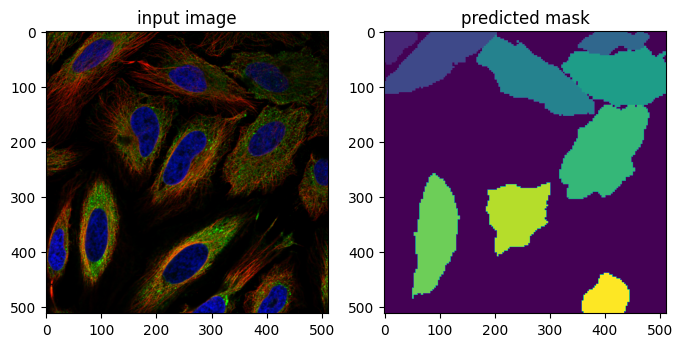

In [14]:
await train(model_id=106, samples=train_samples, epochs=20, resume=True, pretrained_model=None)
await predict(model_id=106, samples=test_samples[:1])

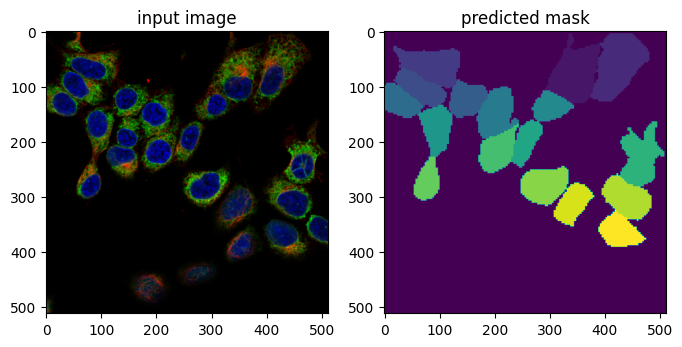

In [15]:
await predict(model_id=106, samples=test_samples[1:2])

In [16]:
valid_image, valid_labels, _ = train_samples[0]
await download_model(model_id=106, valid_image=valid_image, valid_labels=valid_labels)

if IS_PYODIDE:
    from imjoy import api
    # Display the file browser, so you can download the model
    # by right click on the zip file and choose download
    async def setup():
        fm = await api.createWindow(
            src="https://jupyter.imjoy.io/elFinder/index.html"
        )

    api.export({"setup": setup})


Exporting cellpose model: 106
Saving model cellpose-bioimageio-106.zip...
Model package saved to cellpose-bioimageio-106.zip
